<a href="https://www.kaggle.com/code/fbasampaio/german-credit-analysis-score-0-88?scriptVersionId=224876598" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#                             **German Credit Analysis**

We will explore in this data analysis the behaviour of German borrowers. 

The selected attributes are:
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

Data base original: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

Date of data:  11/16/1994



**Import Libraries**

In [1]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

#-------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#-------------------------------------
from scipy.stats import shapiro

#-------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#-------------------------------------
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc

#-------------------------------------
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

#-------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier, RandomForestClassifier


#------------------------------------- 
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

**Define functions**

In [2]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------
def outlier_detect_normal(df, col):
    m = df[col].mean()
    s = df[col].std()
    return df[((df[col]-m)/s).abs()>3]

# ----------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------
def preprocess(df, col):
    print("************************* {} *************************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(8,5))
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.show()
    

# ----------------------------------------------
CV = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
def RandomSearch_Tune(model, Data, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='accuracy', cv = CV, n_jobs=-1)
    clf.fit(X, y)
    
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    
    return (clf.best_score_)

# ----------------------------------------------
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False,)
    return(vif)

**Data Understanding**

In [3]:
# Importing our data

df = pd.read_csv("/kaggle/input/teste10/german_credit_data (2).csv",index_col=0)

df.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.shape

(1000, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


In [7]:
df.isnull().sum().sort_values(ascending=False)

Checking account    394
Saving accounts     183
Age                   0
Sex                   0
Job                   0
Housing               0
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Risk
good    700
bad     300
Name: count, dtype: int64

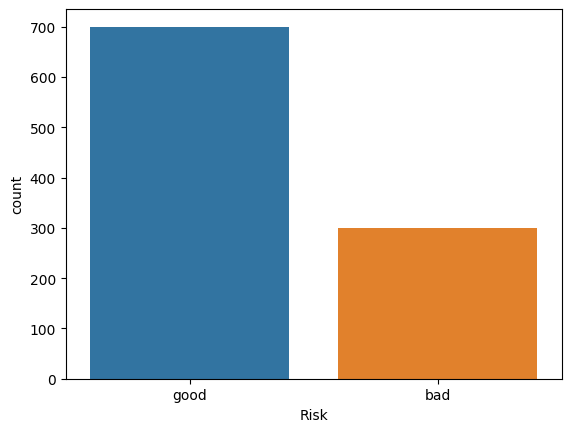

In [8]:
sns.countplot(x = "Risk", data = df)
df.loc[:, 'Risk'].value_counts()

Summary:
- There is an imbalance of risk
- There are null values ​​in two columns

**Manage Missing Data**

In [9]:
df.rename(columns={'Saving accounts': 'Saving_accounts'}, inplace=True)

df['Saving_accounts'] = df['Saving_accounts'].replace(' ', np.nan, regex=True)

df['Saving_accounts'] = df['Saving_accounts'].map({'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4})

df['Saving_accounts'] = pd.to_numeric(df['Saving_accounts'])

print("Mode: {}".format(df['Saving_accounts'].mode()))
print("Mean: {}".format(df['Saving_accounts'].mean()))
print("Median: {}".format(df['Saving_accounts'].median()))

Mode: 0    1.0
Name: Saving_accounts, dtype: float64
Mean: 1.3275862068965518
Median: 1.0


In [10]:
df['Saving_accounts'] = df['Saving_accounts'].fillna(df.Saving_accounts.median())

In [11]:
# Renomear a coluna para eliminar espaços (se necessário)
df.rename(columns={'Checking account': 'Checking_account'}, inplace=True)

# Substituir valores em branco por NaN
df['Checking_account'] = df['Checking_account'].replace(' ', np.nan, regex=True)


# Converter para numérico
df['Checking_account'] = pd.to_numeric(df['Saving_accounts'])

# Agora você pode calcular as estatísticas descritivas
print("Mode: {}".format(df['Checking_account'].mode()))
print("Mean: {}".format(df['Checking_account'].mean()))
print("Median: {}".format(df['Checking_account'].median()))

Mode: 0    1.0
Name: Checking_account, dtype: float64
Mean: 1.247
Median: 1.0


In [12]:
df['Checking_account'] = df['Checking_account'].fillna(df.Checking_account.median())

In [13]:
df.isnull().sum().sort_values(ascending=False)

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [14]:
columns = df.columns
print("******************* Numeric field *******************\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes!=object:
        print("unique number of {} -> {}".format(columns[i], len(df[columns[i]].unique())))
        
print("\n******************* Categorical field *******************\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes==object:
        print("unique number of {} -> {}".format(columns[i], len(df[columns[i]].unique())))

******************* Numeric field *******************

unique number of Age -> 53
unique number of Job -> 4
unique number of Saving_accounts -> 3
unique number of Checking_account -> 3
unique number of Credit amount -> 921
unique number of Duration -> 33

******************* Categorical field *******************

unique number of Sex -> 2
unique number of Housing -> 3
unique number of Purpose -> 8
unique number of Risk -> 2


In [15]:
categorical_feature = df.dtypes==object
final_categorical_feature = df.columns[categorical_feature].tolist()
# ---------------------------------------------------------
final_numeric_feature = ['Age', 'Credit amount', 'Duration']

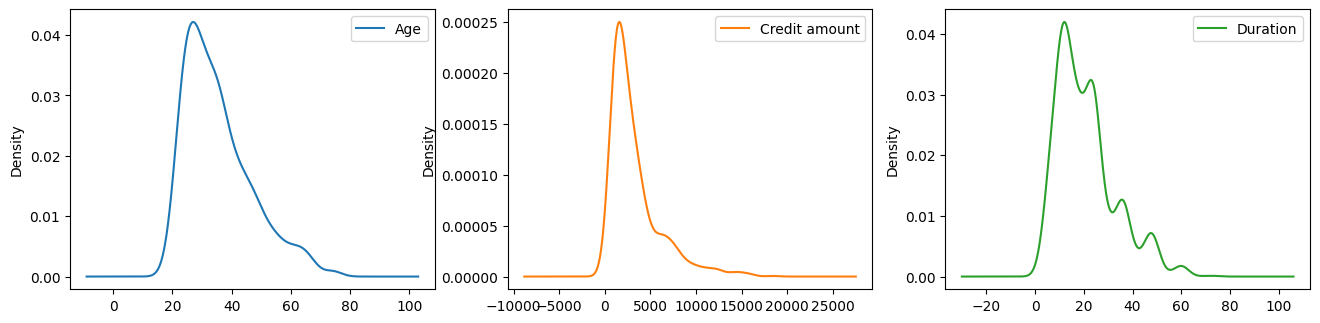

In [16]:
df[final_numeric_feature].plot(kind='density', subplots=True, layout=(2,3), sharex=False, figsize= (16,8))
plt.show()

In [17]:
for i in range(len(final_numeric_feature)):
    stat,p = shapiro(df[final_numeric_feature[i]])
    print(final_numeric_feature[i])
    print('P_value=%.3f' % (p))
    print("*******************************")

Age
P_value=0.000
*******************************
Credit amount
P_value=0.000
*******************************
Duration
P_value=0.000
*******************************


A good result is P Value equal to 0

**Manage Outlier**

In [18]:
df_numeric = df[final_numeric_feature]
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

In [19]:
 for i in range(len(final_numeric_feature)):
    print("IQR => {}: {}".format(final_numeric_feature[i],(outlier_detect(df[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("Z_Score => {}: {}".format(final_numeric_feature[i],(outlier_detect_normal(df[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("********************************")

IQR => Age: 23
Z_Score => Age: 7
********************************
IQR => Credit amount: 72
Z_Score => Credit amount: 25
********************************
IQR => Duration: 70
Z_Score => Duration: 14
********************************


************************* Age *************************

lower outlier: 0 ****** upper outlier: 23



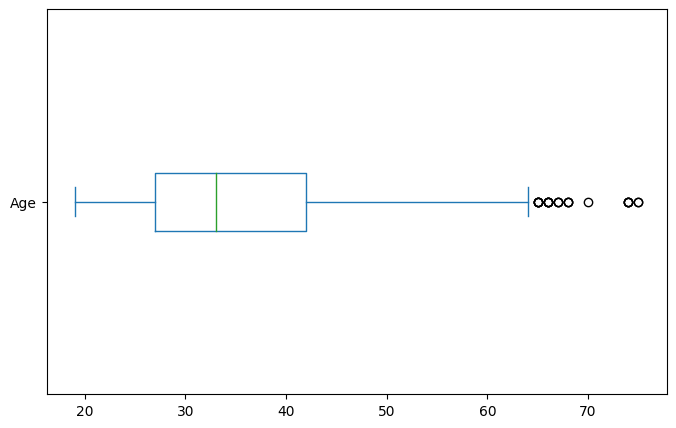

************************* Credit amount *************************

lower outlier: 0 ****** upper outlier: 72



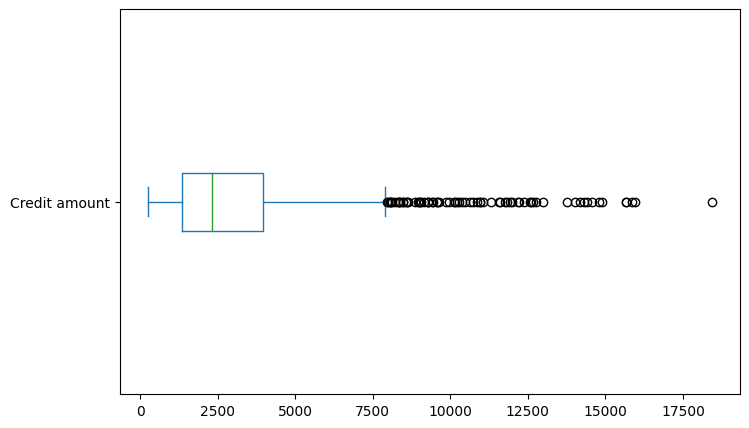

************************* Duration *************************

lower outlier: 0 ****** upper outlier: 70



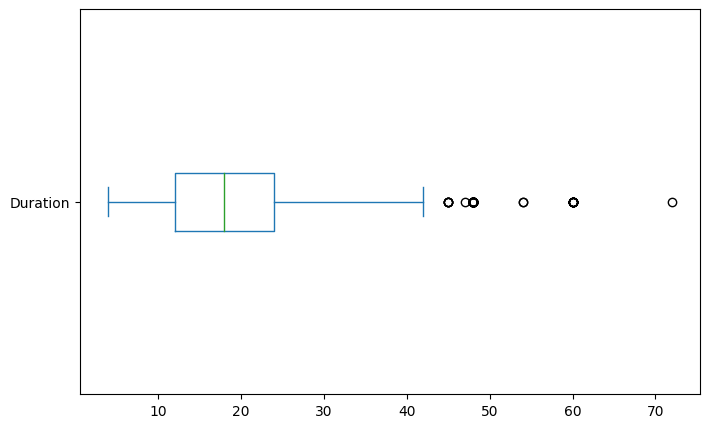

In [20]:
for i in range(len(final_numeric_feature)):
    preprocess(df[final_numeric_feature], final_numeric_feature[i])

**Categorical field**


In [21]:
for i in range(len(final_categorical_feature)):
    print("\n************ {} ************".format(final_categorical_feature[i]))
    print(df[final_categorical_feature[i]].unique())


************ Sex ************
['male' 'female']

************ Housing ************
['own' 'free' 'rent']

************ Purpose ************
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']

************ Risk ************
['good' 'bad']


**Convert qualitative data to quantitative**

In [22]:
le = LabelEncoder() 
df[final_categorical_feature] = df[final_categorical_feature].apply(lambda col: le.fit_transform(col)) 
df.head(5)

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,1.0,1.0,1169,6,5,1
1,22,0,2,1,1.0,1.0,5951,48,5,0
2,49,1,1,1,1.0,1.0,2096,12,3,1
3,45,1,2,0,1.0,1.0,7882,42,4,1
4,53,1,2,0,1.0,1.0,4870,24,1,0


In [23]:
df.loc[df.duplicated()].shape

(0, 10)

In [24]:
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_accounts     0
Checking_account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

<Axes: >

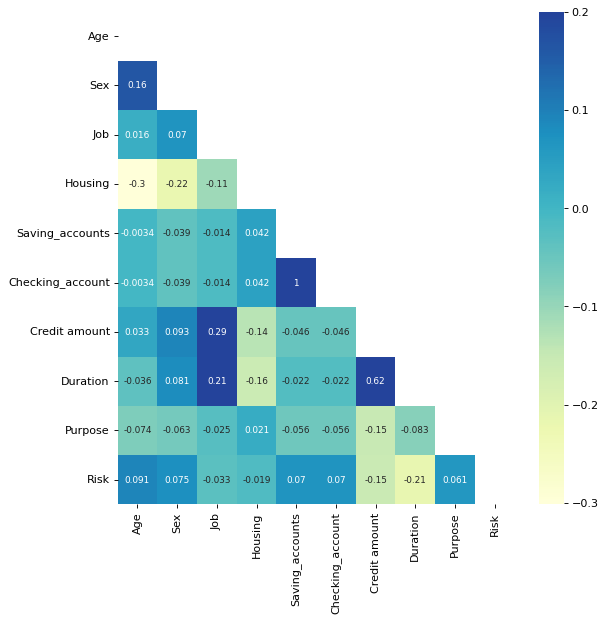

In [25]:
mask = np.triu(np.ones_like(df.corr()))
fig, ax = plt.subplots(figsize=(8,8),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), mask= mask, cmap="YlGnBu", vmax=.2, annot = True, center = 0,annot_kws={"fontsize":8})

**Balancing Data**

In [26]:
x = df.drop("Risk", axis = 1)
y = df['Risk']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state =100 ,stratify=y, test_size = 0.2)
print(y_train.value_counts())

Risk
1    560
0    240
Name: count, dtype: int64


In [28]:
scale = MinMaxScaler()
col = x_train.columns

x_train[col] = scale.fit_transform(x_train[col])
x_test[col] = scale.transform(x_test[col])

**Feature Selction**

In [29]:
sfs = SFS(GradientBoostingClassifier(n_estimators=100, random_state=0),
          k_features = 7,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1).fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    3.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.6s finished

[2025-02-27 21:39:23] Features: 1/7 -- score: 0.7[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.0s finished

[2025-02-27 21:39:24] Features: 2/7 -- score: 0.6987499999999999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.0s finished

[2025-02-27 21:39:25] Features: 3/7 -- score: 0.7024999999999999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.6

In [30]:
print("Best features: ",sfs.k_feature_names_)
print("Best score: ",sfs.k_score_)

Best features:  ('Age', 'Sex', 'Housing', 'Saving_accounts', 'Checking_account', 'Credit amount', 'Purpose')
Best score:  0.6875


In [31]:
x_train_new = x_train[['Age', 'Sex', 'Housing', 'Saving_accounts', 'Checking_account', 'Credit amount', 'Purpose']]
x_test_new = x_test[['Age', 'Sex', 'Housing', 'Saving_accounts', 'Checking_account', 'Credit amount', 'Purpose']]

**Train/Test Split & Normalization**


**Decision Tree Classifier**

In [32]:
DT = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=0)
DT.fit(x_train_new, y_train)

y_test_pred_DT = DT.predict(x_test_new)
y_train_pred_DT = DT.predict(x_train_new)

test_acc_DT = accuracy_score(y_test, y_test_pred_DT)
train_acc_DT = accuracy_score(y_train, y_train_pred_DT)
scores_DT = cross_val_score(DT, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_DT = precision_score(y_test, y_test_pred_DT)
recall_score_DT = recall_score(y_test, y_test_pred_DT)
f1_score_DT = f1_score(y_test, y_test_pred_DT)
conf_DT = confusion_matrix(y_test, y_test_pred_DT)


print("Tain set Accuracy: ", train_acc_DT)
print("Test set Accuracy: ", test_acc_DT)
print("cv:  %s\n"% scores_DT.mean())
print("************************************************")
print("precision_score: ", precision_score_DT)
print("recall_score: ", recall_score_DT)
print("f1_score: ", f1_score_DT)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_DT))

Tain set Accuracy:  0.73625
Test set Accuracy:  0.715
cv:  0.6537499999999999

************************************************
precision_score:  0.7195767195767195
recall_score:  0.9714285714285714
f1_score:  0.8267477203647415
************************************************

Report:
              precision    recall  f1-score   support

           0       0.64      0.12      0.20        60
           1       0.72      0.97      0.83       140

    accuracy                           0.71       200
   macro avg       0.68      0.54      0.51       200
weighted avg       0.69      0.71      0.64       200




**Gradient Boosting Classifier**

In [33]:
from sklearn.model_selection import cross_val_score

GB = GradientBoostingClassifier(criterion='friedman_mse', loss='exponential',
                                min_samples_leaf=4, min_samples_split=6,
                                n_estimators=25, random_state=0)

GB.fit(x_train_new, y_train)

y_test_pred_GB = GB.predict(x_test_new)
y_train_pred_GB = GB.predict(x_train_new)

test_acc_GB = accuracy_score(y_test, y_test_pred_GB)
train_acc_GB = accuracy_score(y_train, y_train_pred_GB)
scores_GB = cross_val_score(GB, x_train_new, y_train, cv=10, scoring='accuracy')

precision_score_GB = precision_score(y_test, y_test_pred_GB)
recall_score_GB = recall_score(y_test, y_test_pred_GB)
f1_score_GB = f1_score(y_test, y_test_pred_GB)
conf_GB = confusion_matrix(y_test, y_test_pred_GB)

print("Train set Accuracy: ", train_acc_GB)
print("Test set Accuracy: ", test_acc_GB)
print("Cross-validation mean accuracy: %s\n" % scores_GB.mean())
print("************************************************")
print("Precision score: ", precision_score_GB)
print("Recall score: ", recall_score_GB)
print("F1 score: ", f1_score_GB)
print("************************************************")
print("\nClassification Report:\n%s\n" % classification_report(y_test, y_test_pred_GB))


Train set Accuracy:  0.7225
Test set Accuracy:  0.715
Cross-validation mean accuracy: 0.6950000000000001

************************************************
Precision score:  0.7106598984771574
Recall score:  1.0
F1 score:  0.8308605341246291
************************************************

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        60
           1       0.71      1.00      0.83       140

    accuracy                           0.71       200
   macro avg       0.86      0.53      0.46       200
weighted avg       0.80      0.71      0.61       200




**Support Vector Classifier**

In [34]:
SVM = SVC(C=10, gamma=0.5, kernel='poly', random_state=0, probability=True)
SVM.fit(x_train_new, y_train)

y_test_pred_SVM = SVM.predict(x_test_new)
y_train_pred_SVM = SVM.predict(x_train_new)

test_acc_SVM = accuracy_score(y_test, y_test_pred_SVM)
train_acc_SVM = accuracy_score(y_train, y_train_pred_SVM)
scores_SVM = cross_val_score(SVM, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_SVM = precision_score(y_test, y_test_pred_SVM, average='macro')
recall_score_SVM = recall_score(y_test, y_test_pred_SVM, average='macro')
f1_score_SVM = f1_score(y_test, y_test_pred_SVM, average='macro')
conf_SVM = confusion_matrix(y_test, y_test_pred_SVM)


print("Tain set Accuracy: ", train_acc_SVM)
print("Test set Accuracy: ", test_acc_SVM)
print("cv:  %s\n"% scores_SVM.mean())
print("************************************************")
print("precision_score: ", precision_score_SVM)
print("recall_score: ", recall_score_SVM)
print("f1_score: ", f1_score_SVM)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_SVM))

Tain set Accuracy:  0.71375
Test set Accuracy:  0.705
cv:  0.7025

************************************************
precision_score:  0.8517587939698492
recall_score:  0.5083333333333333
f1_score:  0.42937279365539927
************************************************

Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.03        60
           1       0.70      1.00      0.83       140

    accuracy                           0.70       200
   macro avg       0.85      0.51      0.43       200
weighted avg       0.79      0.70      0.59       200




**Random Forest Classifier**

In [35]:
RF = RandomForestClassifier(criterion='entropy', min_samples_leaf=2, n_estimators=25,
                       random_state=0)

RF.fit(x_train_new, y_train)

y_test_pred_RF = RF.predict(x_test_new)
y_train_pred_RF = RF.predict(x_train_new)

test_acc_RF = accuracy_score(y_test, y_test_pred_RF)
train_acc_RF = accuracy_score(y_train, y_train_pred_RF)
scores_RF= cross_val_score(RF, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_RF = precision_score(y_test, y_test_pred_RF)
recall_score_RF = recall_score(y_test, y_test_pred_RF)
f1_score_RF = f1_score(y_test, y_test_pred_RF)
conf_RF = confusion_matrix(y_test, y_test_pred_RF)


print("Tain set Accuracy: ", train_acc_RF)
print("Test set Accuracy: ", test_acc_RF)
print("cv:  %s\n"% scores_RF.mean())
print("************************************************")
print("precision_score: ", precision_score_RF)
print("recall_score: ", recall_score_RF)
print("f1_score: ", f1_score_RF)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_RF))

Tain set Accuracy:  0.88625
Test set Accuracy:  0.68
cv:  0.67625

************************************************
precision_score:  0.7159090909090909
recall_score:  0.9
f1_score:  0.7974683544303798
************************************************

Report:
              precision    recall  f1-score   support

           0       0.42      0.17      0.24        60
           1       0.72      0.90      0.80       140

    accuracy                           0.68       200
   macro avg       0.57      0.53      0.52       200
weighted avg       0.63      0.68      0.63       200




**MLPClassifier**


In [36]:
MLP = MLPClassifier(hidden_layer_sizes=10, learning_rate_init=0.1, random_state=0,
              solver='sgd')
MLP.fit(x_train_new, y_train)

y_test_pred_MLP = MLP.predict(x_test_new)
y_train_pred_MLP = MLP.predict(x_train_new)

test_acc_MLP = accuracy_score(y_test, y_test_pred_MLP)
train_acc_MLP = accuracy_score(y_train, y_train_pred_MLP)
scores_MLP = cross_val_score(MLP, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_MLP = precision_score(y_test, y_test_pred_MLP)
recall_score_MLP = recall_score(y_test, y_test_pred_MLP)
f1_score_MLP = f1_score(y_test, y_test_pred_MLP)
conf_MLP = confusion_matrix(y_test, y_test_pred_MLP)


print("Tain set Accuracy: ", train_acc_MLP)
print("Test set Accuracy: ", test_acc_MLP)
print("cv:  %s\n"% scores_MLP.mean())
print("************************************************")
print("precision_score: ", precision_score_MLP)
print("recall_score: ", recall_score_MLP)
print("f1_score: ", f1_score_MLP)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_MLP))

Tain set Accuracy:  0.7
Test set Accuracy:  0.7
cv:  0.6975

************************************************
precision_score:  0.7
recall_score:  1.0
f1_score:  0.8235294117647058
************************************************

Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.70      1.00      0.82       140

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200




**Extra Trees Classifier**


In [37]:
 ET = ExtraTreesClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                     n_estimators=200, random_state=0)
ET.fit(x_train_new, y_train)

y_test_pred_ET = ET.predict(x_test_new)
y_train_pred_ET = ET.predict(x_train_new)

test_acc_ET = accuracy_score(y_test, y_test_pred_ET)
train_acc_ET = accuracy_score(y_train, y_train_pred_ET)
scores_ET = cross_val_score(ET, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_ET = precision_score(y_test, y_test_pred_ET)
recall_score_ET = recall_score(y_test, y_test_pred_ET)
f1_score_ET = f1_score(y_test, y_test_pred_ET)
conf_ET = confusion_matrix(y_test, y_test_pred_ET)


print("Tain set Accuracy: ", train_acc_ET)
print("Test set Accuracy: ", test_acc_ET)
print("cv:  %s\n"% scores_ET.mean())
print("************************************************")
print("precision_score: ", precision_score_ET)
print("recall_score: ", recall_score_ET)
print("f1_score: ", f1_score_ET)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_ET))


Tain set Accuracy:  0.70125
Test set Accuracy:  0.7
cv:  0.7

************************************************
precision_score:  0.7
recall_score:  1.0
f1_score:  0.8235294117647058
************************************************

Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.70      1.00      0.82       140

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200




**Logistic Regression**


In [38]:
LR = LogisticRegression(C=2, penalty='l1', random_state=0, solver='liblinear')
LR.fit(x_train_new, y_train)

y_test_pred_LR = LR.predict(x_test_new)
y_train_pred_LR = LR.predict(x_train_new)

test_acc_LR = accuracy_score(y_test, y_test_pred_LR)
train_acc_LR = accuracy_score(y_train, y_train_pred_LR)
scores_LR = cross_val_score(LR, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_LR = precision_score(y_test, y_test_pred_LR)
recall_score_LR = recall_score(y_test, y_test_pred_LR)
f1_score_LR = f1_score(y_test, y_test_pred_LR)
conf_LR = confusion_matrix(y_test, y_test_pred_LR)


print("Tain set Accuracy: ", train_acc_LR)
print("Test set Accuracy: ", test_acc_LR)
print("cv:  %s\n"% scores_LR.mean())
print("************************************************")
print("precision_score: ", precision_score_LR)
print("recall_score: ", recall_score_LR)
print("f1_score: ", f1_score_LR)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_LR))


Tain set Accuracy:  0.7075
Test set Accuracy:  0.715
cv:  0.7037500000000001

************************************************
precision_score:  0.7128205128205128
recall_score:  0.9928571428571429
f1_score:  0.8298507462686566
************************************************

Report:
              precision    recall  f1-score   support

           0       0.80      0.07      0.12        60
           1       0.71      0.99      0.83       140

    accuracy                           0.71       200
   macro avg       0.76      0.53      0.48       200
weighted avg       0.74      0.71      0.62       200




**KNeighbors Classifier**


Text(0.5, 1.0, 'Accuracy Scores for Values of k of k-Nearest-Neighbors')

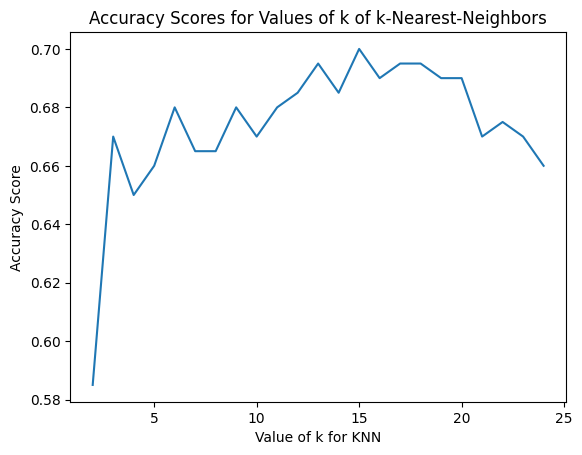

In [39]:
k_range = list(range(2,25))
scores = []

for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(x_train_new, y_train)
    y_pred = KNN.predict(x_test_new)
    scores.append(accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores)


plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')

plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')


In [40]:
d = {'best features number': range(2,25), 'train_score': scores}
df = pd.DataFrame(data=d)
print("max accuracy:",df["train_score"].max())
print("max accuracy id:",df["train_score"].idxmax())

max accuracy: 0.7
max accuracy id: 13


**KNeighbors Classifier**

In [41]:
KNN = KNeighborsClassifier(n_neighbors=8)
KNN.fit(x_train_new, y_train)

y_test_pred_KNN = KNN.predict(x_test_new)
y_train_pred_KNN = KNN.predict(x_train_new)

test_acc_KNN = accuracy_score(y_test, y_test_pred_KNN)
train_acc_KNN = accuracy_score(y_train, y_train_pred_KNN)
scores_KNN = cross_val_score(KNN, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_KNN = precision_score(y_test, y_test_pred_KNN)
recall_score_KNN = recall_score(y_test, y_test_pred_KNN)
f1_score_KNN = f1_score(y_test, y_test_pred_KNN)
conf_KNN = confusion_matrix(y_test, y_test_pred_KNN)

print("Tain set Accuracy: ", train_acc_KNN)
print("Test set Accuracy: ", test_acc_KNN)
print("cv:  %s\n"% scores_KNN.mean())
print("************************************************")
print("precision_score: ", precision_score_KNN)
print("recall_score: ", recall_score_KNN)
print("f1_score: ", f1_score_KNN)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_KNN))

Tain set Accuracy:  0.7375
Test set Accuracy:  0.665
cv:  0.6425

************************************************
precision_score:  0.718562874251497
recall_score:  0.8571428571428571
f1_score:  0.7817589576547231
************************************************

Report:
              precision    recall  f1-score   support

           0       0.39      0.22      0.28        60
           1       0.72      0.86      0.78       140

    accuracy                           0.67       200
   macro avg       0.56      0.54      0.53       200
weighted avg       0.62      0.67      0.63       200




**Stacking Classifier**

In [42]:
estimators = [('DT', DT),
              ('RF', RF),
              ('SVM', SVM),
              ('MLP', MLP),
              ('ET', ET),
              ('LR', LR),
              ('KNN', KNN),
              ('GB', GB),
             ]

SC_tune_LR = StackingClassifier(estimators = estimators, final_estimator = LR)
SC_tune_LR.fit(x_train_new, y_train)

y_test_pred_SC_tune_LR = SC_tune_LR.predict(x_test_new)
y_train_pred_SC_tune_LR = SC_tune_LR.predict(x_train_new)

test_acc_SC_tune_LR = accuracy_score(y_test, y_test_pred_SC_tune_LR)
train_acc_SC_tune_LR = accuracy_score(y_train, y_train_pred_SC_tune_LR)
scores_SC_tune_LR = cross_val_score(SC_tune_LR, x_train_new , y_train , cv = 10, scoring = 'accuracy' )


precision_score_SC_tune_LR = precision_score(y_test, y_test_pred_SC_tune_LR)
recall_score_SC_tune_LR = recall_score(y_test, y_test_pred_SC_tune_LR)
f1_score_SC_tune_LR = f1_score(y_test, y_test_pred_SC_tune_LR)
conf_SC_tune_LR = confusion_matrix(y_test, y_test_pred_SC_tune_LR)

print("Tain set Accuracy: ", train_acc_SC_tune_LR)
print("Test set Accuracy: ", test_acc_SC_tune_LR)
print("cv:  %s\n"% scores_SC_tune_LR.mean())
print("************************************************")
print("precision_score: ", precision_score_SC_tune_LR)
print("recall_score: ", recall_score_SC_tune_LR)
print("f1_score: ", f1_score_SC_tune_LR)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_SC_tune_LR))

Tain set Accuracy:  0.71625
Test set Accuracy:  0.715
cv:  0.69875

************************************************
precision_score:  0.7106598984771574
recall_score:  1.0
f1_score:  0.8308605341246291
************************************************

Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        60
           1       0.71      1.00      0.83       140

    accuracy                           0.71       200
   macro avg       0.86      0.53      0.46       200
weighted avg       0.80      0.71      0.61       200




**Compare Models**

In [43]:
models = []
models.append(('DT', DT))
models.append(('RF', RF))
models.append(('MLP', MLP))
models.append(('ET', ET))
models.append(('LR', LR))
models.append(('KNN', KNN))
models.append(('GB', GB))
models.append(('SC', SC_tune_LR))
models.append(('SVM', SVM))



results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=100, shuffle=True)
    cv_results = cross_val_score(model, x_train_new, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    score = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(score)

DT: 0.657500 (0.050374)
RF: 0.663750 (0.059280)
MLP: 0.690000 (0.062948)
ET: 0.700000 (0.062998)
LR: 0.703750 (0.053048)
KNN: 0.653750 (0.047120)
GB: 0.698750 (0.056306)
SC: 0.700000 (0.058630)
SVM: 0.702500 (0.062948)


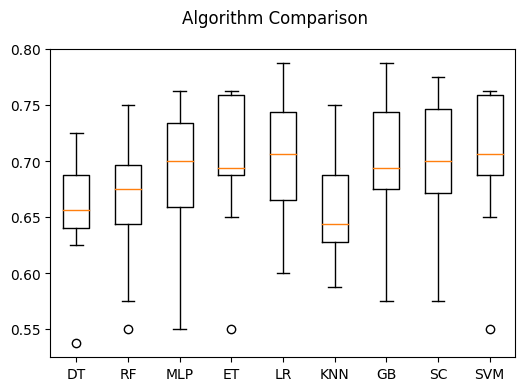

In [44]:
fig = plt.figure(figsize=(6,4))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


In [45]:
compare_models = [('Decision Tree', train_acc_DT, test_acc_DT, scores_DT.mean(), precision_score_DT, recall_score_DT, f1_score_DT, ''),
          ('Random Forest', train_acc_RF, test_acc_RF, scores_RF.mean(), precision_score_RF, recall_score_RF, f1_score_RF, 'The first best'),
          ('Neural Network', train_acc_MLP, test_acc_MLP, scores_MLP.mean(), precision_score_MLP, recall_score_MLP, f1_score_MLP,''),
          ('Extra Tree', train_acc_ET, test_acc_ET, scores_ET.mean(), precision_score_ET, recall_score_ET, f1_score_ET,''),
          ('Logistic Regression', train_acc_LR, test_acc_LR, scores_LR.mean(), precision_score_LR, recall_score_LR, f1_score_LR,''),
          ('KNN', train_acc_KNN, test_acc_KNN, scores_KNN.mean(), precision_score_KNN, recall_score_KNN, f1_score_KNN,'The second best'),
          ('SVC', train_acc_SVM, test_acc_SVM, scores_SVM.mean(), precision_score_SVM, recall_score_SVM, f1_score_SVM,''),
          ('GradientBoosting', train_acc_GB, test_acc_GB, scores_GB.mean(), precision_score_GB, recall_score_GB, f1_score_GB,''),
          ('Stacking', train_acc_SC_tune_LR, test_acc_SC_tune_LR, scores_SC_tune_LR.mean(), precision_score_SC_tune_LR, recall_score_SC_tune_LR, f1_score_SC_tune_LR,'')
         ]

In [46]:
predict = pd.DataFrame(data = compare_models, columns=['Model', 'Train_accuracy', 'Test_accuracy', 'CV_score','precision_score', 'recall_score', 'f1_score', 'Description'])
predict.style.background_gradient(cmap='YlGn')

,Model,Train_accuracy,Test_accuracy,CV_score,precision_score,recall_score,f1_score,Description
0,Decision Tree,0.736250,0.715000,0.653750,0.719577,0.971429,0.826748,
1,Random Forest,0.886250,0.680000,0.676250,0.715909,0.900000,0.797468,The first best
2,Neural Network,0.700000,0.700000,0.697500,0.700000,1.000000,0.823529,
3,Extra Tree,0.701250,0.700000,0.700000,0.700000,1.000000,0.823529,
4,Logistic Regression,0.707500,0.715000,0.703750,0.712821,0.992857,0.829851,
5,KNN,0.737500,0.665000,0.642500,0.718563,0.857143,0.781759,The second best
6,SVC,0.713750,0.705000,0.702500,0.851759,0.508333,0.429373,
7,GradientBoosting,0.722500,0.715000,0.695000,0.710660,1.000000,0.830861,
8,Stacking,0.716250,0.715000,0.698750,0.710660,1.000000,0.830861,


**The first best --> RF**

In [47]:
conf_matrix_RF = confusion_matrix(y_test, y_test_pred_RF)

<Axes: >

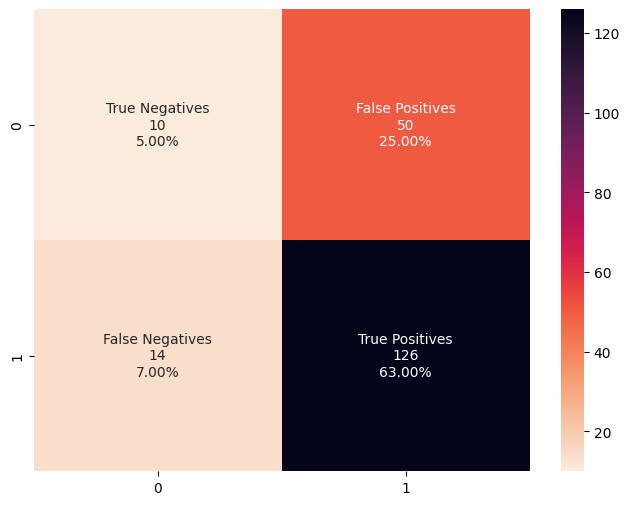

In [48]:
plt.figure(figsize=(8,6))
group_names = ['True Negatives', 'False Positives','False Negatives','True Positives']
group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix_RF.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix_RF.flatten()/np.sum(conf_matrix_RF)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_RF, annot=labels, fmt= '', cmap="rocket_r")

**The second best --> KNN**

In [49]:
conf_matrix_knn = confusion_matrix(y_test, y_test_pred_SC_tune_LR)

<Axes: >

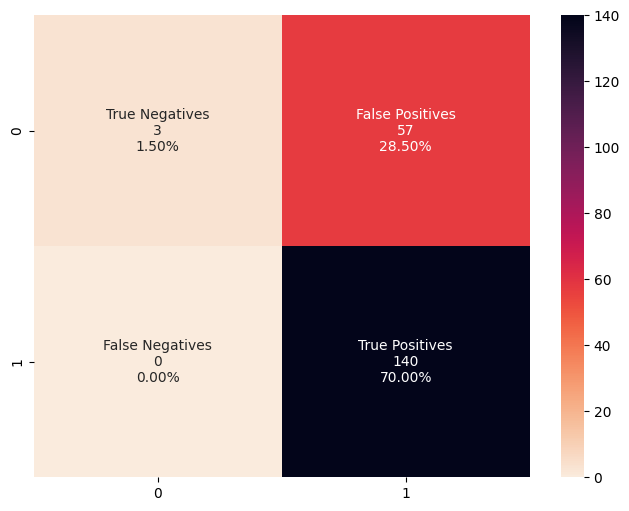

In [50]:
plt.figure(figsize=(8,6))
group_names = ['True Negatives', 'False Positives','False Negatives','True Positives']
group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix_knn.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix_knn.flatten()/np.sum(conf_matrix_knn)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_knn, annot=labels, fmt= '', cmap="rocket_r")

**Confusion_matrix for cross_val_predict**

In [51]:
y_pred_cross_val_RF = cross_val_predict(RF, x_test_new, y_test, cv=10)
conf_matrix_cross_val_RF = confusion_matrix(y_test, y_pred_cross_val_RF)

<Axes: >

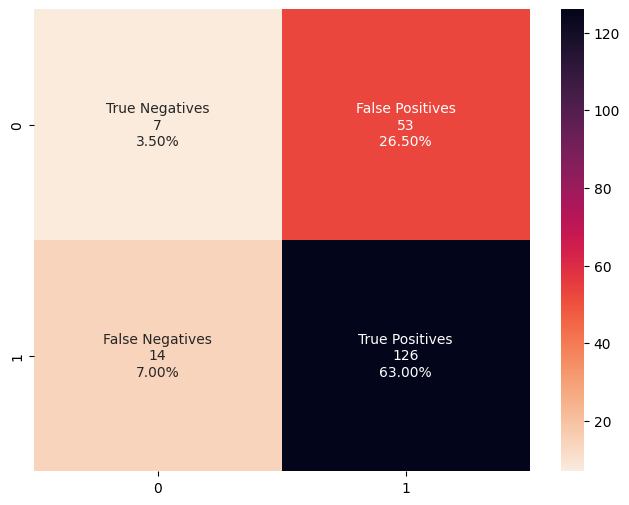

In [52]:
plt.figure(figsize=(8,6))
group_names = ['True Negatives', 'False Positives','False Negatives','True Positives']
group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix_cross_val_RF.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix_cross_val_RF.flatten()/np.sum(conf_matrix_cross_val_RF)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_cross_val_RF, annot=labels, fmt= '', cmap="rocket_r")